In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [2]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

# forecasting web traffic in chess.com

we have the monthly historic traffic data from chess.com webpage from January 2012 to March 2023.

In [3]:
df = pd.read_csv('data/chess-1.csv')

In [4]:
df.head(5)

,date,traffic
0,2016-12,1526174
1,2017-01,1771862
2,2017-02,2335786
3,2017-03,3342238
4,2017-04,3826931


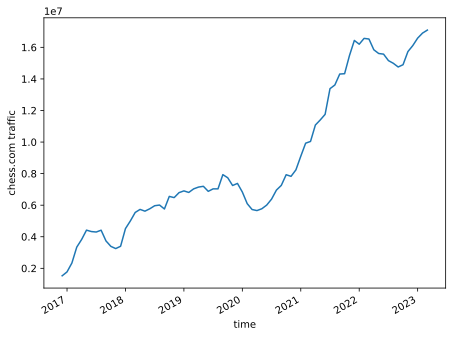

In [5]:
fig, ax = plt.subplots()

ax.plot(df.traffic)

ax.set_xlabel('time')
ax.set_ylabel('chess.com traffic')


ax.set_xticks(
    np.arange(1, 75, 12),
    np.arange(2017, 2024, 1),
)

fig.autofmt_xdate()
plt.tight_layout()
#plt.show()

plt.savefig('obs-1.svg')

Let us decompose the series, to see the trend seasonality, and the residuals.

In [6]:
# the period is equal to the frequency
# STL stands for Season-Trend decomposition using LOESS.
# for testing.
train = df.traffic[:-3]
decomposition = sm.tsa.STL(train, period = 12).fit()

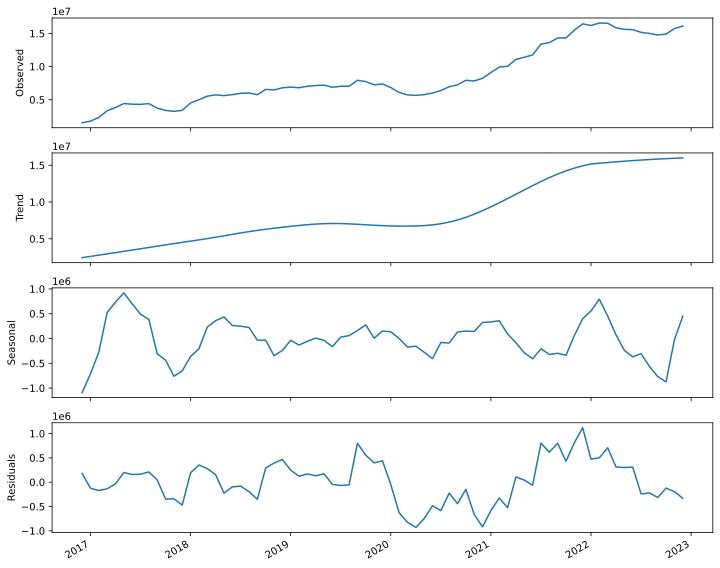

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows = 4, ncols = 1, 
    sharex = True, 
    figsize=(10,8)
) 

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
plt.xticks(
    np.arange(1, 75, 12),
    np.arange(2017, 2024, 1),
)

fig.autofmt_xdate()
plt.tight_layout()


plt.savefig('decom.svg')

## check for stationarity 

In [8]:
adf = sm.tsa.stattools.adfuller(train)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -0.3478905011926536
p-value 0.9184424088589132


In [9]:
traffic_diff = np.diff(train, n = 1)
adf = sm.tsa.stattools.adfuller(traffic_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -3.1888530246108675
p-value 0.02063904476074973


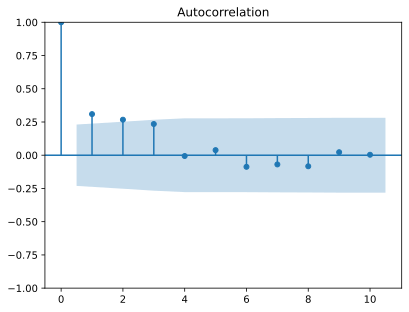

In [10]:
sm.graphics.tsa.plot_acf(traffic_diff, lags=10)
plt.show()

#FIXME add why it is not a random walk

## find p, q and P, Q

In [11]:
ps = range(0, 6) 
qs = range(0, 6)
Ps = [0]
Qs = [0]

d = 1
D = 0
s = 12

# list with all combinations posible for p,q,P,Q
order_l = list(itertools.product(ps, qs, Ps, Qs))

In [12]:
import tqdm
def optimize_sarima(
        endog: pd.Series | list, order_l: list, 
        d: int, D: int, s:int) -> pd.DataFrame:

    '''
    Given a list of combinations of p,q test different combinations of arma
    orders, and compare them against each other using Akaike Information
    criterion.

    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param order_l list: list of all combinations of p and q
    :param d int: number of times the dataset needs to be diff to become 
                  stationary 

    :returns: dataframe with two columns, one the combination of p and q,
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in tqdm.tqdm_notebook(order_l):
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog,
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

In [13]:
# we will remove last 6 months, meaning we will only take
# the info until decemeber 2022. We will use the last 6 months
# for testing.
train = df.traffic[:-3]

In [14]:
arima_result = optimize_sarima(train, order_l, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

In [15]:
arima_result.head(7)

,"(p,q,P,Q)",AIC
0,"(3, 1, 0, 0)",2078.407462
1,"(0, 5, 0, 0)",2079.774906
2,"(4, 1, 0, 0)",2080.024761
3,"(3, 2, 0, 0)",2080.353652
4,"(2, 3, 0, 0)",2080.360632
5,"(1, 5, 0, 0)",2081.292037
6,"(4, 2, 0, 0)",2081.372609


In [16]:
model = sm.tsa.statespace.SARIMAX(
    train, 
    order = (0, 1, 5),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

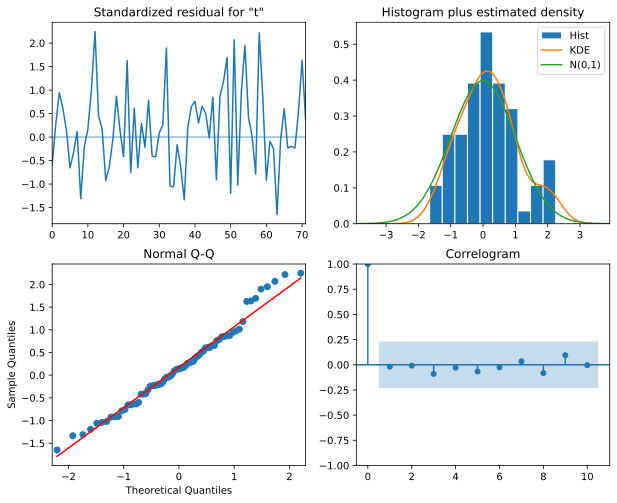

In [17]:
model.plot_diagnostics(figsize = (10, 8));
plt.savefig('diag-31.svg')

In [18]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,0.223525,0.636367
2,0.224023,0.894034
3,0.350533,0.950260
4,0.353390,0.986112
5,0.622547,0.986948
6,0.958996,0.987119
7,0.960127,0.995446
8,1.359014,0.994809
9,1.369780,0.998002
10,1.410772,0.999187


In [19]:
test = df.iloc[-3:]
test

,date,traffic
73,2023-01,16583965
74,2023-02,16902916
75,2023-03,17094718


In [20]:
# The naive seasonal forecast simply reuses the data from 1959 as
# a forecast for 1960.
test['naive_seasonal'] = df.traffic.iloc[70:73].values

In [21]:
test['naive_avg'] = [np.average(df.traffic.iloc[67:73].values)]*3

In [22]:
arima_pred = model.get_prediction(73, 76).predicted_mean
test['arima_05'] = arima_pred
test['arima_31'] = [16412187, 16707268, 16804804]

In [23]:
# Set float format
pd.options.display.float_format = '{:.0f}'.format
test

,date,traffic,naive_seasonal,naive_avg,arima_05,arima_31
73,2023-01,16583965,14898733,15274165,16381638,16412187
74,2023-02,16902916,15730408,15274165,16770711,16707268
75,2023-03,17094718,16110785,15274165,16971533,16804804


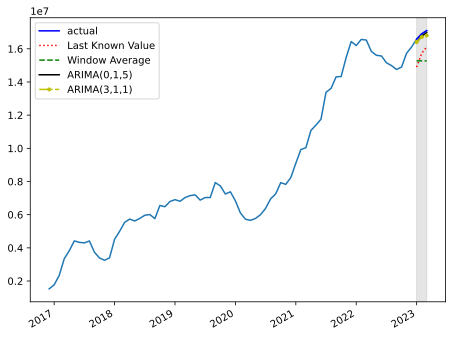

In [24]:
fig, ax = plt.subplots()

ax.plot(df.traffic)
ax.plot(test.traffic, 'b', label = 'actual')
ax.plot(test.naive_seasonal, 'r:', label = 'Last Known Value')
ax.plot(test.naive_avg, 'g--', label = 'Window Average')
ax.plot(test.arima_05, 'k', label = 'ARIMA(0,1,5)')
ax.plot(test.arima_31, 'y.-.', label = 'ARIMA(3,1,1)')


ax.legend(loc = 2)

ax.set_xticks(
    np.arange(1, 75, 12),
    np.arange(2017, 2024, 1),
)

ax.set_xticks(
    np.arange(1, 75, 12),
    np.arange(2017, 2024, 1),
)

ax.axvspan(73, 75, color = '#808080', alpha = 0.2)



fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('forecast.svg')

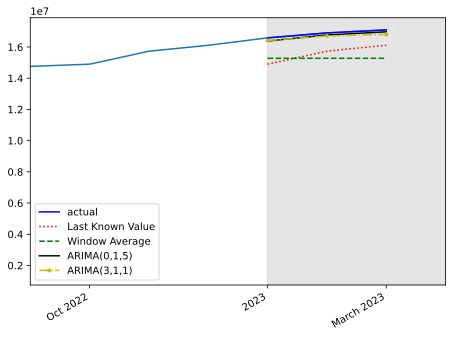

In [25]:
fig, ax = plt.subplots()

ax.plot(df.traffic)
ax.plot(test.traffic, 'b', label = 'actual')
ax.plot(test.naive_seasonal, 'r:', label = 'Last Known Value')
ax.plot(test.naive_avg, 'g--', label = 'Window Average')
ax.plot(test.arima_05, 'k', label = 'ARIMA(0,1,5)')
ax.plot(test.arima_31, 'y.-.', label = 'ARIMA(3,1,1)')



ax.legend(loc =  "lower left")

ax.set_xticks(
    np.arange(1, 75, 12),
    np.arange(2017, 2024, 1),
)

ax.set_xticks(
    [70, 73, 75],
    ["Oct 2022", "2023", "March 2023"],
)

ax.axvspan(73, 76, color = '#808080', alpha = 0.2)

ax.set_xlim(69, 76)


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('forecast-close.svg')

In [26]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mape_naive_seasonal = mape(test.traffic, test.naive_seasonal)
mape_arima31 = mape(test.traffic, test.arima_31)
mape_arima05 = mape(test.traffic, test.arima_05)
mape_avg = mape(test.traffic, test.naive_avg)

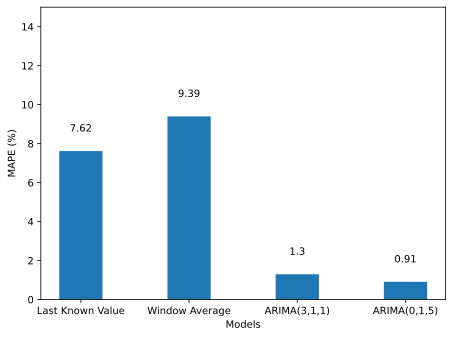

In [28]:
fig, ax = plt.subplots()

x = ['Last Known Value', 'Window Average', 'ARIMA(3,1,1)', 'ARIMA(0,1,5)']
y = [mape_naive_seasonal, mape_avg, mape_arima31, mape_arima05]


ax.bar(x, y, width = 0.4)

ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(
        x = index, y = value + 1, s = str(round(value, 2)), ha = 'center'
    )
    
plt.tight_layout()
plt.savefig('mape.svg')